# 应用机器学习的建议(一)

原文来自https://jmetzen.github.io/2015-01-29/ml_advice.html 翻译参考来自http://blog.jobbole.com/85680/  本人对初始代码做了一些修改以适应运行，并且加入一些额外的内容。
这篇文章是以Bremen大学机器学习课程的教程为基础的。本文总结了使用机器学习解决新问题的一些建议。包括：

 * 可视化数据的方法
 * 选择一个适合当前问题的机器学习方法
 * 鉴别和解决过拟合和欠拟合问题
 * 处理大数据库问题（注意：不是非常小的）
 * 不同损失函数的利弊

本文以Andrew Ng的 ["Advice for applying Machine Learning"](http://see.stanford.edu/materials/aimlcs229/ML-advice.pdf) 为基础。这个笔记的目的是用一个互动的方法解释这些观点。有些建议是可以讨论的。它们仅是建议，不是严格的规则。

In [3]:
import time
import numpy as np
np.random.seed(0)

In [4]:
import matplotlib.pyplot as plt
import seaborn as sns


In [5]:

# Modified from http://scikit-learn.org/stable/auto_examples/plot_learning_curve.html
from sklearn.learning_curve import learning_curve
def plot_learning_curve(estimator, title, X, y, ylim=None, cv=None,
                        train_sizes=np.linspace(.1, 1.0, 5)):
    """
    Generate a simple plot of the test and traning learning curve.

    Parameters
    ----------
    estimator : object type that implements the "fit" and "predict" methods
        An object of that type which is cloned for each validation.

    title : string
        Title for the chart.

    X : array-like, shape (n_samples, n_features)
        Training vector, where n_samples is the number of samples and
        n_features is the number of features.

    y : array-like, shape (n_samples) or (n_samples, n_features), optional
        Target relative to X for classification or regression;
        None for unsupervised learning.

    ylim : tuple, shape (ymin, ymax), optional
        Defines minimum and maximum yvalues plotted.

    cv : integer, cross-validation generator, optional
        If an integer is passed, it is the number of folds (defaults to 3).
        Specific cross-validation objects can be passed, see
        sklearn.cross_validation module for the list of possible objects
    """
    
    plt.figure()
    train_sizes, train_scores, test_scores = learning_curve(
        estimator, X, y, cv=5, n_jobs=1, train_sizes=train_sizes)
    train_scores_mean = np.mean(train_scores, axis=1)
    train_scores_std = np.std(train_scores, axis=1)
    test_scores_mean = np.mean(test_scores, axis=1)
    test_scores_std = np.std(test_scores, axis=1)

    plt.fill_between(train_sizes, train_scores_mean - train_scores_std,
                     train_scores_mean + train_scores_std, alpha=0.1,
                     color="r")
    plt.fill_between(train_sizes, test_scores_mean - test_scores_std,
                     test_scores_mean + test_scores_std, alpha=0.1, color="g")
    plt.plot(train_sizes, train_scores_mean, 'o-', color="r",
             label="Training score")
    plt.plot(train_sizes, test_scores_mean, 'o-', color="g",
             label="Cross-validation score")

    plt.xlabel("Training examples")
    plt.ylabel("Score")
    plt.legend(loc="best")
    plt.grid("on") 
    if ylim:
        plt.ylim(ylim)
    plt.title(title)

### 数据集

我们使用[sklearn](http://scikit-learn.org)的make_classification函数来生成一些简单的玩具数据： 

In [6]:
from sklearn.datasets import make_classification
X, y = make_classification(1000, n_features=20, n_informative=2, 
                           n_redundant=2, n_classes=2, random_state=0)

from pandas import DataFrame
df = DataFrame(np.hstack((X, y[:, None])), 
               columns = list(range(20)) + ["class"])

注意到我们为二分类生成了一个数据集，这个数据集包括1000个数据点，每个特征20维。我们已经使用pandas的DataFrame类把数据和类别封装到一个共同的数据结构中。我们来看一看前5个数据点：

In [7]:
df[:5]

,0,1,2,3,4,5,6,7,8,9,...,11,12,13,14,15,16,17,18,19,class
0,-1.063780,0.676409,1.069356,-0.217580,0.460215,-0.399167,-0.079188,1.209385,-0.785315,-0.172186,...,-0.993119,0.306935,0.064058,-1.054233,-0.527496,-0.074183,-0.355628,1.057214,-0.902592,0
1,0.070848,-1.695281,2.449449,-0.530494,-0.932962,2.865204,2.435729,-1.618500,1.300717,0.348402,...,0.225324,0.605563,-0.192101,-0.068027,0.971681,-1.792048,0.017083,-0.375669,-0.623236,1
2,0.940284,-0.492146,0.677956,-0.227754,1.401753,1.231653,-0.777464,0.015616,1.331713,1.084773,...,-0.050120,0.948386,-0.173428,-0.477672,0.760896,1.001158,-0.069464,1.359046,-1.189590,1
3,-0.299517,0.759890,0.182803,-1.550233,0.338218,0.363241,-2.100525,-0.438068,-0.166393,-0.340835,...,1.178724,2.831480,0.142414,-0.202819,2.405715,0.313305,0.404356,-0.287546,-2.847803,1
4,-2.630627,0.231034,0.042463,0.478851,1.546742,1.637956,-1.532072,-0.734445,0.465855,0.473836,...,-1.061194,-0.888880,1.238409,-0.572829,-1.275339,1.003007,-0.477128,0.098536,0.527804,0


通过直接查看原始特征值，我们很难获得该问题的任何线索，即使在这个低维的例子中。因此，有很多的提供数据的更容易视图的方法；其中的小部分将在接下来的部分中讨论。

### 可视化

当你接到一个新的问题，第一步几乎都是可视化，也就是说，观察你的数据。

[Seaborn](http://stanford.edu/~mwaskom/software/seaborn/)是一个不错的统计数据可视化包。我们使用它的一些函数来探索数据。

第一步是使用pairplot生成散点图和直方图。两种颜色对应了两个类别，我们使用了特征的一个子集、仅仅使用前50个数据点来简化问题。


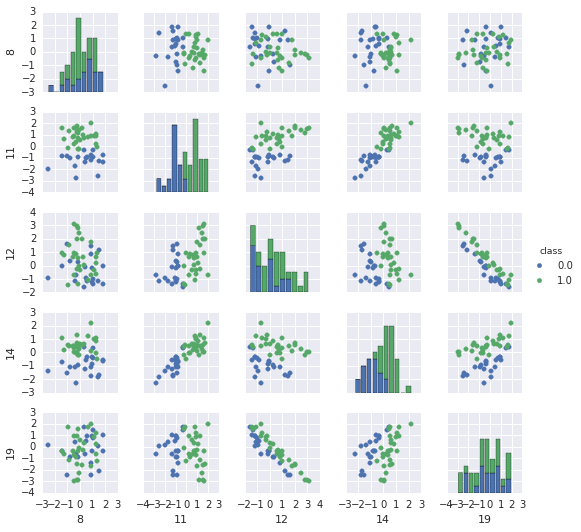

In [8]:
_ = sns.pairplot(df[:50], vars=[8, 11, 12, 14, 19], hue="class", size=1.5)

基于该直方图，我们可以看到一些特征比其他特征对分类更有用。特别地，特征11和14看起来有丰富的信息量。这两个特征的散点图显示类别在二维空间中几乎是线性可分的。要更加注意的是，特征12和19是高度负相关的。我们可以通过使用corrplot更系统地探索相关性：

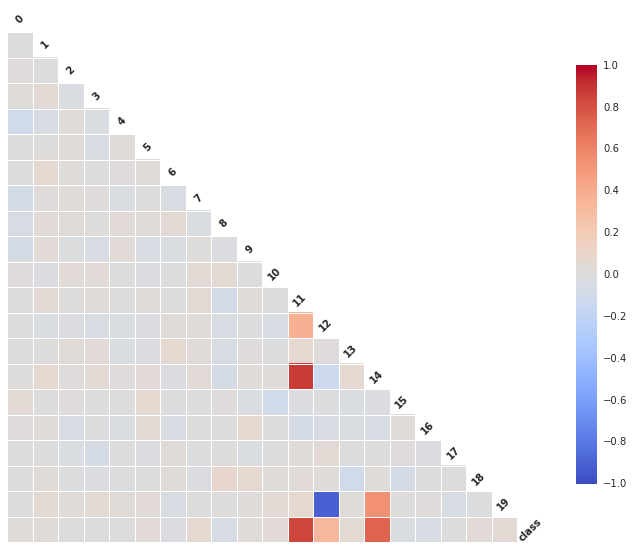

In [9]:
plt.figure(figsize=(12, 10))
_ = sns.corrplot(df, annot=False)

我们可以发现我们之前的观察结果在这里得到了确认：特征11和14与类强相关（他们有丰富的信息量）。更进一步，特征12和特征19强负相关，特征19和特征14强相关。因此，有一些特征是冗余的。这对于有些分类器可能会出现问题，比如，朴素贝叶斯，它假设所有的特征都是独立的。剩下的特征大部分都是噪声，他们既不相互关联，也不和类别相关。

注意到如果特征维数较大、数据点较少的时候，数据可视化会变得更有挑战性。我们在后面会给出一个高维数据可视化的例子。

### 方法的选择

一旦我们已经使用可视化方法对数据进行了探索，我们就可以开始应用机器学习了。机器学习方法数量众多，通常很难决定先尝试哪种方法。这个简单的单[备忘单](http://peekaboo-vision.blogspot.de/2013/01/machine-learning-cheat-sheet-for-scikit.html)（归功于Andreas Müller和sklearn团队）可以帮助你为你的问题选择一个合适的机器学习方法（供选择的备忘录见http://dlib.net/ml_guide.svg）

![](http://i12.tietuku.cn/7d050e32c1d77bb8.png)

我们有了1000个样本，要预测一个类别，并且有了标签，那么备忘单推荐我们首先使用LinearSVC（LinearSVC代表线性核的支持向量分类，并且对于这类特殊问题使用一个有效的算法）。所有我们做了个试验。LinearSVC需要选择正则化；我们使用标准L2范数惩罚和C=10.我们分别画出训练分数和验证分数的学习曲线（这个例子中分数代表准确率）：

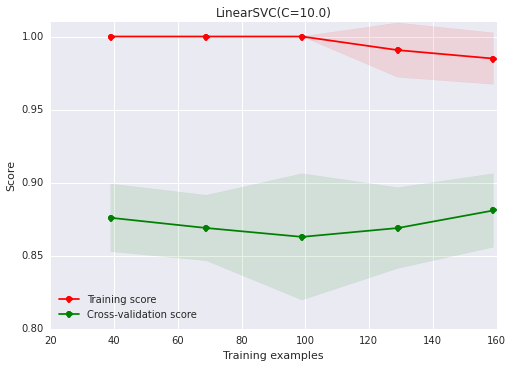

In [10]:
from sklearn.svm import LinearSVC
plot_learning_curve(LinearSVC(C=10.0), "LinearSVC(C=10.0)",
                    X, y, ylim=(0.8, 1.01),
                    train_sizes=np.linspace(.05, 0.2, 5))

我们可以注意到训练数据和交叉验证数据的错误率有很大的差距。这意味什么？我们可能过度拟合训练数据了！

### 过度拟合

要理解为什么这会发生，一个人必须考虑在任何数据集里出现的噪声量。一个人可以设一个数据由$D_{T}$和$\epsilon$,组成, 其中$D_{T}$为我们建模过程中得到的真实数据部分,而$\epsilon$则是一些随机噪声. 因为我们可以认为整个方程为 $D = D_{T} + \epsilon$, 我们可能会发现模型对给定的$\epsilon$会有非常不错的拟合，但是并不是对整个序列有很好的拟合。

这是有问题的，因为我们只关心整体序列方程对样本的拟合，并认为这会带来对未来数据的精准预测。两个宽泛的过度拟合的原因是：

* 样本小，所以趋势并不显著
* 选择了一个过于复杂的模型，所以这会使得模型变得扭曲从而对样本里的噪声进行拟合。

### 解决过拟合

有很多方法来减少过拟合：
* **增加训练样本数**

（获得更多的数据是机器学习从业者的共同愿望）


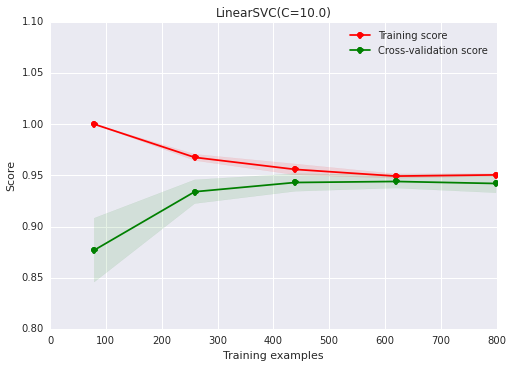

In [11]:
plot_learning_curve(LinearSVC(C=10.0), "LinearSVC(C=10.0)",
                    X, y, ylim=(0.8, 1.1),
                    train_sizes=np.linspace(.1, 1.0, 5))

可以看到当训练数据增加时，验证分数越来越大，差距越来越小；因此现在不再过拟合了。有很多获得更多数据的方法，比如（a）可以尽力投资收集更多数据，（b）基于现有数据创造一些人为的数据（比如图像旋转，平移，扭曲），或者（c）加入人工噪声。

如果以上的这些方法都不可行，就不可能获得更多的数据，我们或者可以:


* **减少特征的维数**

（从我们可视化中可以知道，特征11和14是信息量最大的）


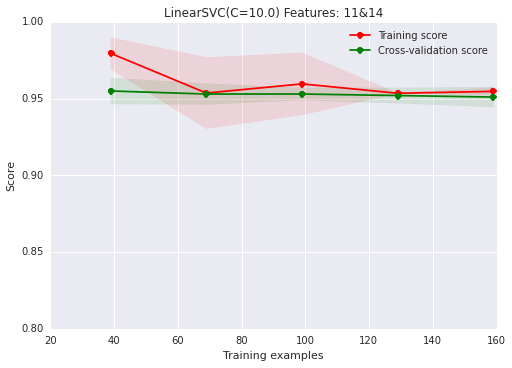

In [12]:
plot_learning_curve(LinearSVC(C=10.0), "LinearSVC(C=10.0) Features: 11&14",
                    X[:, [11, 14]], y, ylim=(0.8, 1.0),
                    train_sizes=np.linspace(.05, 0.2, 5))

注意到，因为我们是手动的挑选特征，而且在比我们给分类器更多的数据上，这有一点作弊的意味。我们可以使用自动挑选特征：

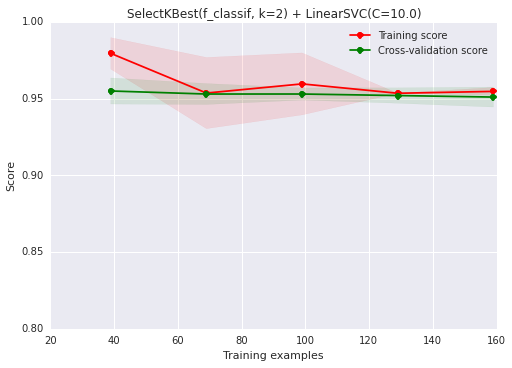

In [13]:
from sklearn.pipeline import Pipeline
from sklearn.feature_selection import SelectKBest, f_classif
# SelectKBest(f_classif, k=2) will select the k=2 best features according to their Anova F-value

plot_learning_curve(Pipeline([("fs", SelectKBest(f_classif, k=2)), # select two features
                               ("svc", LinearSVC(C=10.0))]),
                    "SelectKBest(f_classif, k=2) + LinearSVC(C=10.0)",
                    X, y, ylim=(0.8, 1.0),
                    train_sizes=np.linspace(.05, 0.2, 5))

这样做效果非常好。在这个toy数据集上，特征选择是简单的。应该注意到特征选择只是减少模型复杂度的一个特殊种类。其他的方法是：（a）减少线性回归多项式模型的次数，（b）减少人工神经网络节点的个数/层数，（c）增加RBF核的带宽等等。

仍然有一个问题：为什么分类器不能自动的识别有用的特征？首先让我们转向另一种选择，来减少过拟合：

 * **增加分类器的正则化** (减少线性SVC的C的系数）

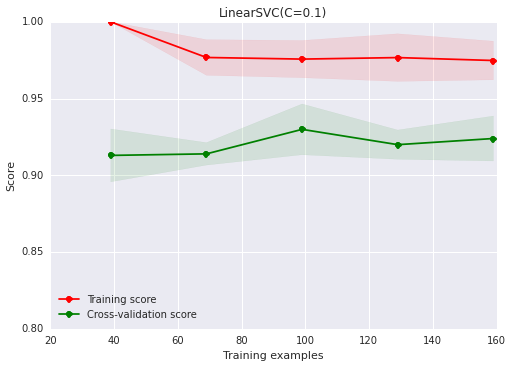

In [14]:
plot_learning_curve(LinearSVC(C=0.1), "LinearSVC(C=0.1)", 
                    X, y, ylim=(0.8, 1.0),
                    train_sizes=np.linspace(.05, 0.2, 5))

这已经有一点点作用了。我们也可以使用基于交叉验证的网格搜索自动地挑选分类器的正则化：

Chosen parameter on 100 datapoints: {'C': 0.01}


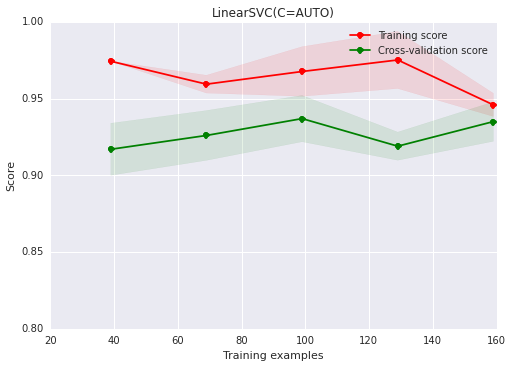

In [15]:
from sklearn.grid_search import GridSearchCV
est = GridSearchCV(LinearSVC(), 
                   param_grid={"C": [0.001, 0.01, 0.1, 1.0, 10.0]})
plot_learning_curve(est, "LinearSVC(C=AUTO)", 
                    X, y, ylim=(0.8, 1.0),
                    train_sizes=np.linspace(.05, 0.2, 5))
print ("Chosen parameter on 100 datapoints: %s" % est.fit(X[:100], y[:100]).best_params_)

一般说来，特征选择似乎更好。分类器可以自动识别有用的特征吗？回想一下，LinearSVC还支持L1范数惩罚，这产生了一个稀疏的解决方案。稀疏解决方案对应一个隐式的特征选择。让我们来试试这个：

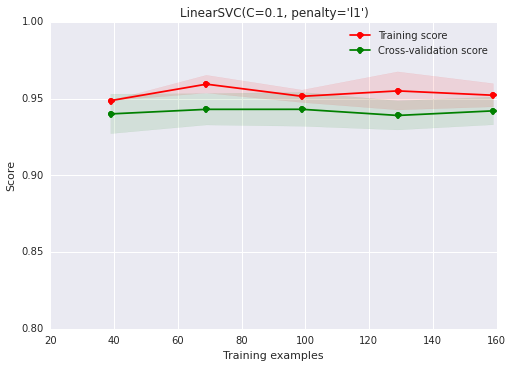

In [16]:
plot_learning_curve(LinearSVC(C=0.1, penalty='l1', dual=False), 
                    "LinearSVC(C=0.1, penalty='l1')", 
                    X, y, ylim=(0.8, 1.0),
                    train_sizes=np.linspace(.05, 0.2, 5))

这看起来也很好。让我们来探讨学到的系数：

In [17]:
est = LinearSVC(C=0.1, penalty='l1', dual=False)
est.fit(X[:150], y[:150])  # fit on 150 datapoints
print("Coefficients learned: %s" % est.coef_)
print ("Non-zero coefficients: %s" % np.nonzero(est.coef_)[1])

Coefficients learned: [[ 0.          0.          0.          0.          0.          0.01857999
   0.          0.          0.          0.004135    0.          1.05241369
   0.01971419  0.          0.          0.          0.         -0.05665314
   0.14106505  0.        ]]
Non-zero coefficients: [ 5  9 11 12 17 18]


大部分系数是0（对应的特征被忽略），并且目前最大的权重在特征11上。

### 不同的数据集

我们生成另外一个二分类的数据集，并且再次应用LinearSVC。

In [18]:
from sklearn.datasets import make_circles
X, y = make_circles(n_samples=1000, random_state=2)

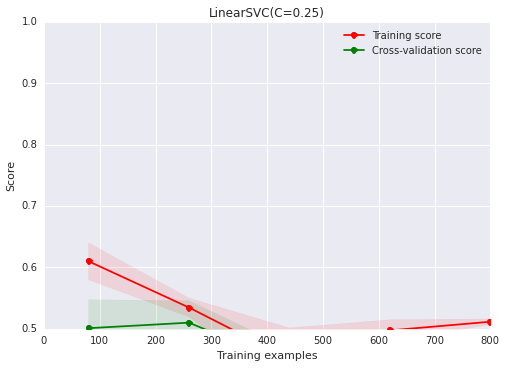

In [19]:
plot_learning_curve(LinearSVC(C=0.25), "LinearSVC(C=0.25)", 
                    X, y, ylim=(0.5, 1.0),
                    train_sizes=np.linspace(.1, 1.0, 5))

啊，这非常糟糕，甚至训练误差都不如随机误差。这个可能的原因是什么？难道上面的所有方法（更多数据，特征选择，增加正则化）都不奏效了吗？

结果是：No。我们处在一个完全不同的情况：以前，训练分数一直接近完美，我们不得不解决过拟合。这次，训练误差也非常低。是**欠拟合**。让我们来看一看数据：

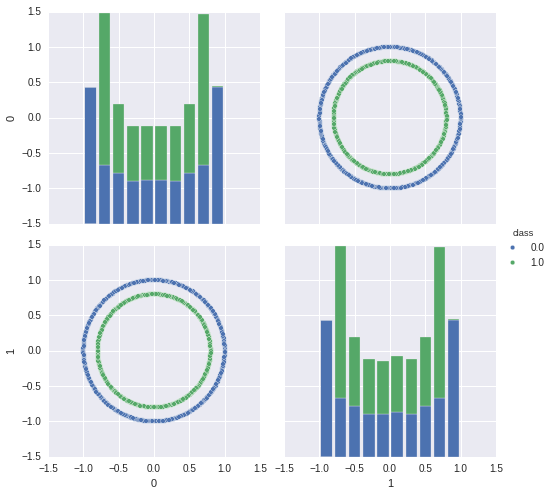

In [19]:
df = DataFrame(np.hstack((X, y[:, None])), 
               columns = range(2) + ["class"])
_ = sns.pairplot(df, vars=[0, 1], hue="class", size=3.5)

这些数据显然不是线性可分的；更多的数据或者更少的特征没有用了。我们的模型错了；因此欠拟合。

### 解决欠拟合

减少欠拟合的方法：
 * **•使用更多或更好的特征** （到原点的距离应该有用！）

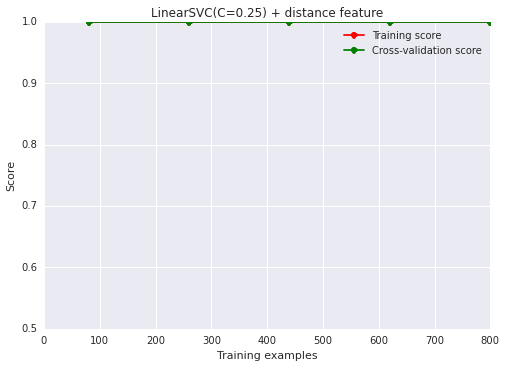

In [20]:
# add squared distance from origin as third feature
X_extra = np.hstack((X, X[:, [0]]**2 + X[:, [1]]**2))

plot_learning_curve(LinearSVC(C=0.25), "LinearSVC(C=0.25) + distance feature", 
                    X_extra, y, ylim=(0.5, 1.0),
                    train_sizes=np.linspace(.1, 1.0, 5))

非常好！但是我们必须要花一些心思来想出这些特征。或许分类器可以自动的做到这些？这需要

 * **使用更复杂的模型**

（减少正则化或非线性核）


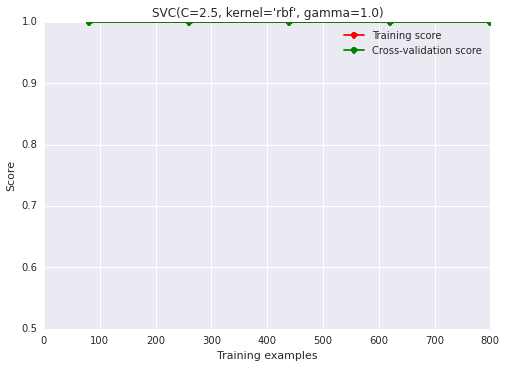

In [21]:
from sklearn.svm import SVC
# note: we use the original X without the extra feature
plot_learning_curve(SVC(C=2.5, kernel="rbf", gamma=1.0),
                    "SVC(C=2.5, kernel='rbf', gamma=1.0)",
                    X, y, ylim=(0.5, 1.0), 
                    train_sizes=np.linspace(.1, 1.0, 5))

是的，这也可以达到满意的效果！